Loading data from ../Real_Env_Test/recv_all_20251022_044355/sensor_data_20251022_044355_1761075868.npz...
✅ 데이터 로드 성공!
------------------------------
  timestamps: (72275,)
  send_timestamps: (72275,)
  forces: (72275,)
  alines: (72275, 1025)
------------------------------


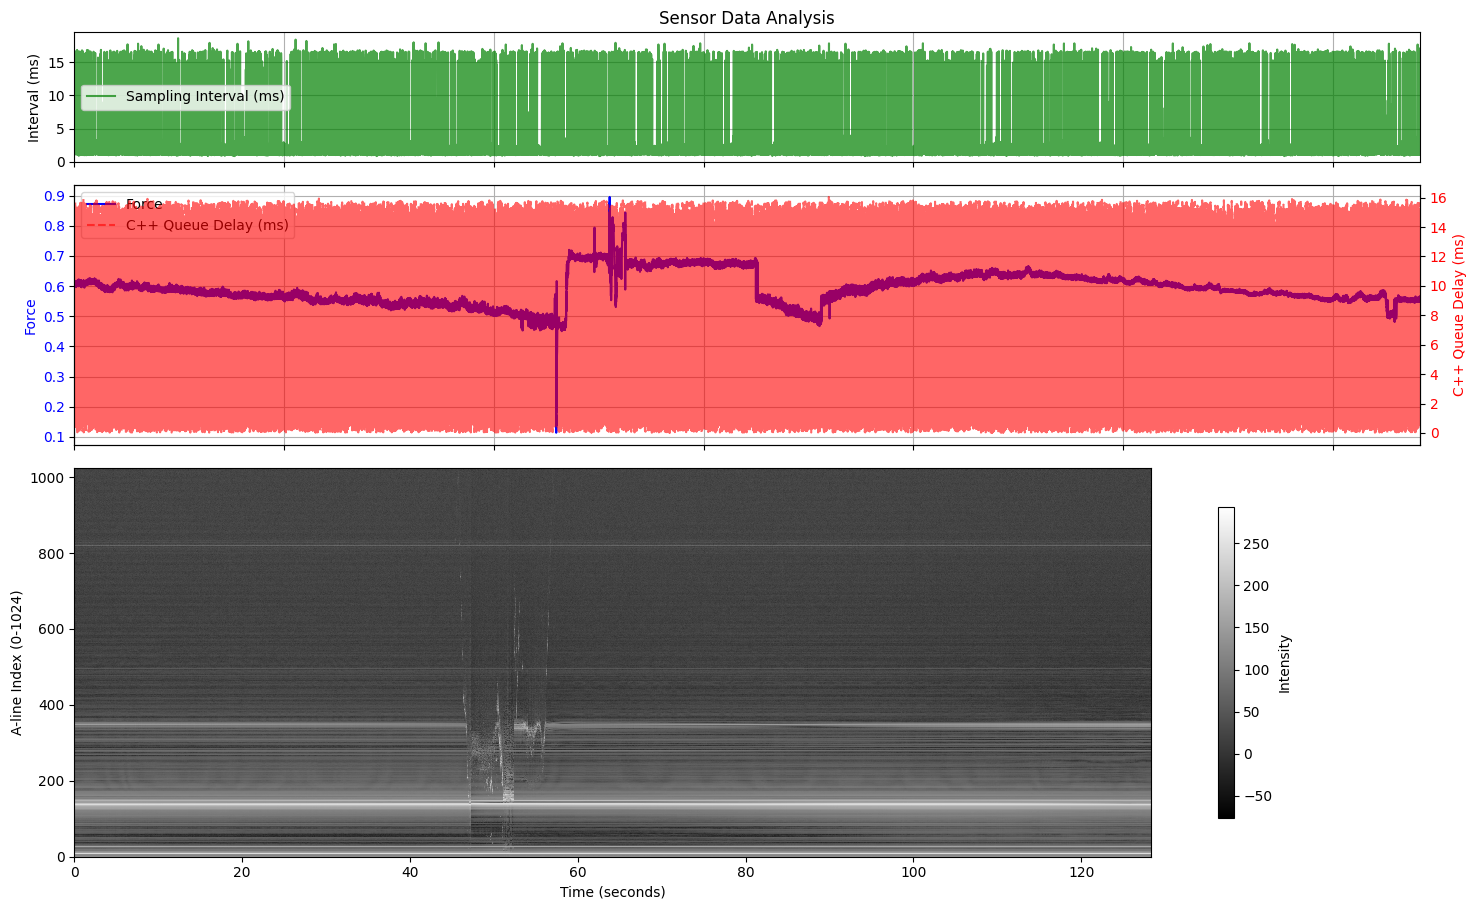

In [3]:
import numpy as np
import matplotlib.pyplot as plt

def load_sensor_data(filename):
    """
    np.savez로 저장된 .npz 파일을 메모리 맵 모드로 불러옵니다.
    """
    print(f"Loading data from {filename}...")
    
    try:
        # mmap_mode='r'로 변경하여 로딩 속도 향상 (압축 안 했을 때 효과적)
        data = np.load(filename, mmap_mode='r') 
        
        timestamps = data['timestamps']
        send_timestamps = data['send_timestamps']
        forces = data['forces']
        alines = data['alines']
        
        print("✅ 데이터 로드 성공!")
        print("-" * 30)
        print(f"  timestamps: {timestamps.shape}")
        print(f"  send_timestamps: {send_timestamps.shape}")
        print(f"  forces: {forces.shape}")
        print(f"  alines: {alines.shape}")
        print("-" * 30)
        
        return {
            "timestamps": timestamps,
            "send_timestamps": send_timestamps,
            "forces": forces,
            "alines": alines
        }

    except FileNotFoundError:
        print(f"[ERROR] 파일을 찾을 수 없습니다: {filename}")
    except Exception as e:
        print(f"[ERROR] 데이터 로드 실패: {e}")
    
    return None

# ▼▼▼ [수정] Matplotlib 시각화 함수 (타임스탬프 정보 추가) ▼▼▼
def visualize_data(data):
    """
    로드된 데이터를 matplotlib을 사용해 시각화합니다.
    1. 측정 간격 (Timestamp difference)
    2. Force (1D) + C++ 큐 지연 (보조 Y축)
    3. A-lines (2D 이미지)
    """
    if not data:
        print("시각화할 데이터가 없습니다.")
        return

    timestamps = data['timestamps']
    send_timestamps = data['send_timestamps']
    forces = data['forces']
    alines = data['alines'] # Shape: (N, 1025)

    if len(timestamps) < 2:
        print("데이터가 너무 적어 간격 계산 및 시각화가 어렵습니다.")
        return

    # 시간 축 계산 (0초부터 시작)
    time_elapsed = timestamps - timestamps[0]

    # 1. 측정 간격 계산 (ms 단위)
    intervals = np.diff(timestamps) * 1000 
    
    # 2. C++ 큐 지연 계산 (ms 단위)
    # send_timestamps와 timestamps 길이가 같으므로 element-wise 연산 가능
    cpp_queue_delay = (send_timestamps - timestamps) * 1000

    # 3개의 플롯을 위아래로 생성 (비율 조정)
    fig, axes = plt.subplots(3, 1, figsize=(15, 10), sharex=True, 
                             gridspec_kw={'height_ratios': [1, 2, 3]}) # 그래프 높이 비율 조절
    ax0, ax1, ax2 = axes # 축 분리

    # --- 0. 측정 간격 그래프 (ax0) ---
    # np.diff는 길이가 N-1 이므로 x축도 맞춰줌
    ax0.plot(time_elapsed[1:], intervals, label='Sampling Interval (ms)', color='g', alpha=0.7)
    ax0.set_ylabel('Interval (ms)')
    ax0.set_title('Sensor Data Analysis')
    ax0.grid(True)
    ax0.legend()

    # --- 1. Force 그래프 (ax1) + C++ 큐 지연 (보조 축) ---
    ax1.plot(time_elapsed, forces, label='Force', color='b')
    ax1.set_ylabel('Force', color='b')
    ax1.tick_params(axis='y', labelcolor='b') # 왼쪽 Y축 색상
    ax1.grid(True)
    
    # 보조 Y축 생성
    ax1_twin = ax1.twinx() 
    ax1_twin.plot(time_elapsed, cpp_queue_delay, label='C++ Queue Delay (ms)', color='r', linestyle='--', alpha=0.6)
    ax1_twin.set_ylabel('C++ Queue Delay (ms)', color='r')
    ax1_twin.tick_params(axis='y', labelcolor='r') # 오른쪽 Y축 색상
    
    # 범례 합치기
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax1_twin.get_legend_handles_labels()
    ax1.legend(lines + lines2, labels + labels2, loc='upper left')
    ax1.legend(lines + lines2, labels + labels2, loc='upper left')


    # --- 2. A-line 이미지 (ax2) ---
    im = ax2.imshow(alines.T, 
                    cmap='gray', # 흑백 컬러맵
                    aspect='auto', 
                    interpolation='nearest',
                    origin='lower',
                    extent=[time_elapsed[0], time_elapsed[-1], 0, alines.shape[1]])
    
    ax2.set_xlabel('Time (seconds)')
    ax2.set_ylabel('A-line Index (0-1024)')
    fig.colorbar(im, ax=ax2, label='Intensity', shrink=0.8) # 컬러바 크기 조절

    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # 그래프 간격 및 제목 공간 확보
    plt.show()
# ▲▲▲ [수정] ▲▲▲

if __name__ == "__main__":
    # 불러올 파일명을 지정합니다.
    filename_to_load = "../Real_Env_Test/recv_all_20251022_044355/sensor_data_20251022_044355_1761075868.npz" 
    
    loaded_data = load_sensor_data(filename_to_load)
    
    if loaded_data:
        visualize_data(loaded_data)